In [28]:
import numpy as np
import csv
import matplotlib.pyplot as plt
import astropy.constants as cte
import astropy.units as un
from astropy.cosmology import Planck15 as cosmo
import emcee
import scipy
from scipy import optimize as op
import corner
import os
os.environ["OMP_NUM_THREADS"] = "4"
from multiprocessing import Pool
import time
from datetime import datetime 

In [2]:
c=cte.c
c_um=c.to("um/s")
c_mm=c.to("mm/s")
Msun=cte.M_sun

In [3]:
file = open("/Users/mariajesusfloresmoraga/Desktop/DSFG/SPT.csv")
csvreader = csv.reader(file)
header = []
header = next(csvreader)

rows = []
for row in csvreader:
        rows.append(row)

ID= []

z=[]

S3=[]
errS3=[]

S2=[]
errS2=[]

S1=[]
errS1=[]

S870=[]
errS870=[]

S500=[]
errS500=[]

S350=[]
errS350=[]

S250=[]
errS250=[]

S160=[]
errS160=[]

S100=[]
errS100=[]

for j in rows:   
    
    ID.append(j[0])
    z.append(float(j[1]))
    S3.append(float(j[2]))
    errS3.append(float(j[3]))
    S2.append(float(j[4]))
    errS2.append(float(j[5]))
    S1.append(float(j[6]))
    errS1.append(float(j[7]))
    S870.append(float(j[8]))
    errS870.append(float(j[9]))
    S500.append(float(j[10]))
    errS500.append(float(j[11]))
    S350.append(float(j[12]))
    errS350.append(float(j[13]))
    S250.append(float(j[14]))
    errS250.append(float(j[15]))
    S160.append(float(j[16]))
    errS160.append(float(j[17]))
    S100.append(float(j[18]))
    errS100.append(float(j[19]))
   

In [4]:
v__=np.array([500,350,250])*un.um
v_=(c_um/v__).to("Hz")
v=v_.value
l__=np.array([90,150,220])*un.GHz
l_=l__.to("Hz")
l=l_.value
vf=np.concatenate((l,v))
print((vf*un.Hz).to("GHz"))

[  90.        150.        220.        599.584916  856.54988  1199.169832] GHz


In [5]:
frecsT_l=[]
errfT_l=[]
for m in range (len(rows)):
    
    frec=[S3[m],S2[m],S1[m],S500[m],S350[m],S250[m]]
    errf=[errS3[m],errS2[m],errS1[m],errS500[m],errS350[m],errS250[m]]
    frecsT_l.append(frec)
    errfT_l.append(errf)

In [6]:
def tau(z,M_,d_,vf): 
    vf=vf*un.Hz
    d_=d_*un.kpc
    v0=353*un.GHz
    b=2
    M=Msun * 10** M_
    k0=0.15*(un.m**2/un.kg) 
    tau=k0*(vf/v0)**b *(z+1)**b * M/(np.pi*(d_/2)**2)
    return tau.to("")

In [7]:
def P(vf,T,z):
    vf=vf*un.Hz
    T=T*un.K
    h=cte.h
    K=cte.k_B
    A=2*h/(c**2)
    a=(h*vf*(1+z)/(K*T))
    B=vf**3/(np.e**(a.value) -1)
    P=(A*B).to("mJy")
    return P

In [8]:
def modelSv(vf,z,T,M_,d_):
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    M=Msun*(10**M_)
    
    TAU=tau(z,M_,d_,vf)
    PL=P(vf,T,z)
    
    vf=vf*un.Hz
    T=T*un.K
    d_=d_*un.kpc
    
    O=np.pi*(d_/2)**2 * (D**-2)
    
    S_=O*(1-np.e**-TAU)*PL
    S=S_.to("mJy")
    return S.value

In [9]:
def A(z,Tc,M_,d_,vf): 


    v0=353*un.GHz
    b=2
    
    Tc=Tc*un.K
    Tvariable=(np.linspace(Tc.value,1000,10000)) *un.K
    
    integrales=[]
    
    for i in vf:
        ARG = modelSv(i,z,Tvariable,M_,d_)*un.mJy *(Tvariable)**-7
        integrales.append(scipy.integrate.trapz(ARG,x=Tvariable))
    
    return integrales

In [10]:
def modelSobs(vf,z,Tc,M_,d_): #Como SPT no entrega Tc tomamos Tc= T-10]
    
    b=2
    v0=353*un.GHz
    D=cosmo.angular_diameter_distance(z)
    TCMB=2.725*un.K
    
    INTEGRAL=A(z,Tc,M_,d_,vf)
    TAU=tau(z,M_,d_,vf)
    
    h=cte.h
    K=cte.k_B
    vf=vf*un.Hz
    d_=d_*un.kpc
    Tc=Tc*un.K
    O=np.pi*(d_/2)**2 * (D**-2)
    model_=[]
    for j in range(len(vf)):
        M1=6 * Tc**6 * INTEGRAL[j]
    
        M2=O * np.e**-TAU * (2*h)/(c**2) * (vf[j]**3)/(np.e**(h*vf[j]/(K*TCMB))-1)
        model_.append(((M1+M2)[0]).value)
        
    model=model_*un.mJy

    return model.value

In [11]:
def ml_S(ID,frecsT): #Single
    
    popt,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4])) 
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    plt.figure(figsize=(12,9))

    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [12]:
def ml_PL_lim(ID,frecsT): #PL
    
    popt,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = popt
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]
    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])
    
    

    plt.plot(x,y,label="MaxL")
    plt.plot(vf,np.array(frecsT),marker="o",label="Data")
    plt.xscale("log")
    plt.yscale("log")
    plt.annotate(r"$z:{},T:{},M:{},d:{}$".format(np.round(z_fit,2),np.round(T_fit,2),np.round(M_fit,2),np.round(d_fit,2)),(5*10**11,5),fontsize=14)

    plt.ylabel("Flux (mJy)",fontsize=14)
    plt.xlabel("Frequency (Hz)",fontsize=14)
    plt.title("MaxL: {}".format(ID),fontsize=14)
    plt.legend()

In [13]:
def lnprior(theta,model):
    z,T,M,d = theta
    if T>0 and z>0 and M>0 and d>0:
        pM= -1 * (M - 9.4)**2 / (0.5 *0.5**2) #prior M (sacado de Su)
        pZ= -1 * (z - 3)**2 / (2 * 2**2) #prior Z 
        pd= -1 * (d - 4)**2 / (2 * 2**2) #prior T
        if model=="S":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior T
        if model=="PL nolim":
            pT= -1 * (T - 55)**2 / (2 * 10**2) #prior Tc (como Tc=T-10, automaticamente restamos 10)
        if model=="PL lim":
            pT= -1 * ((T-10) - 35)**2 / (2 * 10**2) #prior Tc
        return pM+pZ+pd+pT
    return -np.inf

In [14]:
def lnlike(theta,x,y,yerr,model):
    z,T,M_,d_ = theta
    y=np.array(y)
    yerr=np.array(yerr)
    Sv = modelSv(x,z,T,M_,d_)
    Sobs = modelSobs(x,z,T,M_,d_)
    x = x*un.Hz
    if model=="S": 
        inv_sigma2 = 1.0 / (yerr**2 + (Sv)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sv))**2*inv_sigma2 - np.log(inv_sigma2))
    else: 
        inv_sigma2 = 1.0 / (yerr**2 + (Sobs)**2 * np.exp(2*-1))
        lnlike= -0.5 * np.sum((y-(Sobs))**2*inv_sigma2 - np.log(inv_sigma2))
        
    return lnlike

In [15]:
def lnprob(theta, x, y, yerr,model):
    lp = lnprior(theta,model)
    if not(np.isfinite(lp)):
        return -np.inf
    return lp + lnlike(theta, x, y, yerr,model)

In [29]:
def mcmc_S(ID,frecsT,errfT,model): #recibe con unidades
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSv,vf,frecsT,[3.,50.,10.,4.],bounds=([1,10,8,2],[10,100,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSv(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 1000 # 3000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                        pool=pool)
        

        start = time.time()
        sampler.run_mcmc(pos, 50)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))
    
    samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(0,4),(20,65),(7.5,13),(0,6)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])
    
    plt.savefig("Model Single", dpi=600, format='png')
   
    return pm

In [30]:
def mcmc_PL_lim(ID,frecsT,errfT,model): #recibe con unidades

    
    x = np.linspace(90,2000,100)*un.GHz
    x = x.to("Hz")
    x = x.value
    
    
    theta,pconv = scipy.optimize.curve_fit(modelSobs,vf,frecsT,[3.,35.,10.,4.],bounds=([1,20,8,2],[10,50,11,4]))
    
    z_fit,T_fit,M_fit,d_fit = theta
    
    
    plt.figure(figsize=(12,9))


        
    pm = [z_fit,T_fit,M_fit,d_fit]

    y  = modelSobs(x,pm[0],pm[1],pm[2],pm[3])

    ndim, nwalkers = 4, 1000 # 6000 iteraciones
    pos = [theta + 1e-3 * np.random.randn(ndim) for i in range(nwalkers)] 
    
    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob ,args=(vf,np.array(frecsT),np.array(errfT),model),
                                        pool=pool)
        

        start = time.time()
        sampler.run_mcmc(pos, 50)
        end = time.time()
        multi_time = end - start
        print("Multiprocessing took {0:.1f} minutes".format(multi_time/60))
    
    samples = sampler.chain[:, 40:, :].reshape((-1, ndim))
    
    fig = corner.corner(samples,
                    labels=["z", "T", r"$M$", r"$d$"],
                    quantiles=[0.16, 0.5, 0.84],range=[(0,10),(20,65),(7.5,13),(0,6)],
                    show_titles=True,
                    truths=[z_fit,T_fit,M_fit,d_fit])
    
    plt.savefig("PL", dpi=600, format='png')
    
    return pm

In [18]:
z_ref=3
T_ref=50*un.K
M_ref= 10 #np.log10(6.749*2.02*10**9) # log10(Uprom*M/Msun) = log10(Uprom*Mprom*10**9)
d_ref=4*un.kpc

In [19]:
ID[0]

'SPT0002-52'

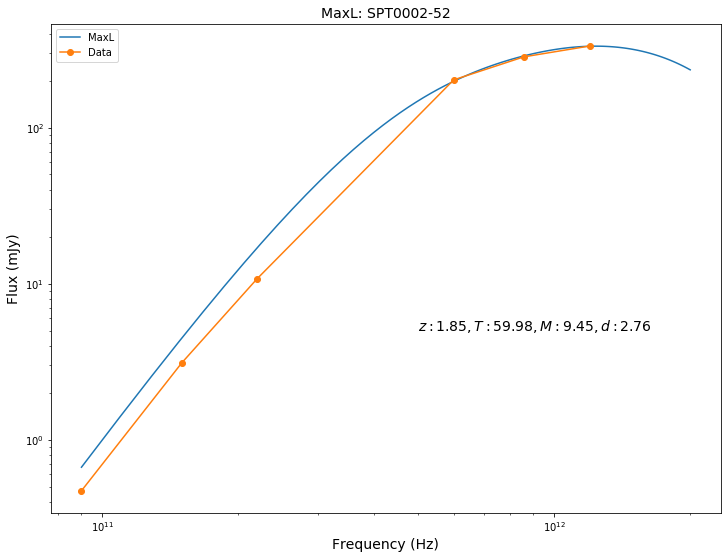

In [20]:
ml_S(ID[0],frecsT_l[0])

Multiprocessing took 15.0 minutes


[1.8495476564465363, 59.97947600836809, 9.450066961847016, 2.7579351182899843]

<Figure size 864x648 with 0 Axes>

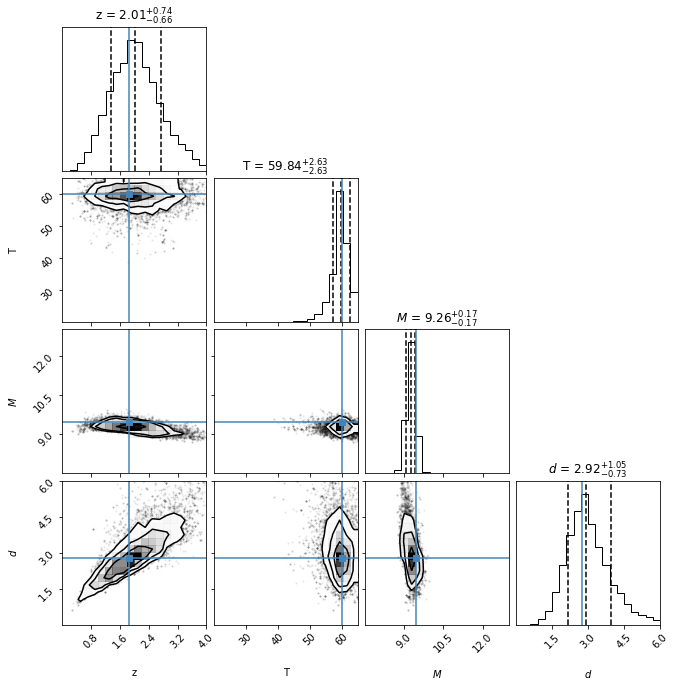

In [31]:
mcmc_S(ID[0],frecsT_l[0],errfT_l[0],"S")

In [ ]:
z_fit=[]
T_fit=[]
M_fit=[]
d_fit=[]
for i in range (len(rows)):
    modeloS= mcmc_S(ID[i],frecsT_l[i],errfT_l[i],"S")
    z_fit.append(modeloS[0])
    T_fit.append(modeloS[1])
    M_fit.append(modeloS[2])
    d_fit.append(modeloS[3])
print(z_fit)

Multiprocessing took 14.8 minutes


Multiprocessing took 15.0 minutes
Multiprocessing took 15.1 minutes


/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:583: RuntimeWarning: invalid value encountered in true_divide
  sm /= sm[-1]
/opt/anaconda3/lib/python3.7/site-packages/corner/core.py:587: RuntimeWarning: invalid value encountered in less_equal
  V[i] = Hflat[sm <= v0][-1]


In [ ]:
for i in range (len(rows)):
    mcmc_PL_lim(ID[i],frecsT_l[i],errfT_l[i],"PL lim")